# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML
import time

In [2]:

# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

# Data


In [3]:

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [6]:
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [7]:

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [10]:
nnvc = nyc_neighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Murray Hill    2
Bay Terrace    2
Chelsea        2
Sunnyside      2
Name: Neighborhood, dtype: int64

In [11]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'Bay Terrace']

Borough Neighborhood   Latitude  Longitude
175         Queens  Bay Terrace  40.782843 -73.776802
235  Staten Island  Bay Terrace  40.553988 -74.139166

In [12]:
for i in range(nyc_neighborhoods.shape[0]):
    nyn_ = nyc_neighborhoods.loc[i, 'Neighborhood']
    if nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = nyc_neighborhoods.loc[j, 'Borough']
            nyc_neighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [13]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

In [15]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [16]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [17]:
CLIENT_ID = 'VARTW2XNKBSWQ2N4TAQTSFFVYPUH24BKX5PDLDTVVXWED0SJ' 
CLIENT_SECRET = 'B0KNKAB0JTQHDHZWBZWMQSFFQ4TL1VKCFVJNYV20FETTMBPC' 
VERSION = '20180605'

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [19]:
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )

••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [20]:
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(nyc_venues.shape)
nyc_venues.head()

(23571, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0                  Shell       40.894187       -73.845862         Gas Station  
1            Pitman Deli       40.894149       -73.845748                Food  
2  Julio C Barber Shop 2       40.892648       -73.855725  Salon / Barbershop  
3       Lollipops Gelato       40.894123       -73.845892        Dessert Shop  
4     Pittman Ave bodega       40.894241       -73.845763   Convenience Store

In [21]:

nyc_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                      83
Annadale                      77
Arden Heights                 68
Arlington                     70
Arrochar                      78
Arverne                       80
Astoria                       73
Astoria Heights               63
Auburndale                    61
Bath Beach                    83
Battery Park City             87
Bay Ridge                     84
Bay Terrace, Queens           81
Bay Terrace, Staten Island    76
Baychester                    79
Bayside                       84
Bayswater                     80
Bedford Park                  68
Bedford Stuyvesant            86
Beechhurst                    89
Bellaire                      77
Belle Harbor                  81
Bellerose                     78
Belmont                       62
Bensonhurst                   83
Bergen Beach                  77
Blissville                    77
Bloomfield                    73
Boerum Hill                   88
Borough Park                  

In [22]:

nyc_neighborhoods.shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 306)

In [23]:
nyc_excluded_neighborhoods = set(nyc_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

In [24]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 580 uniques categories.


In [25]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
nyc_onehot['Neighborhood_'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0     Wakefield    0                  0              0               0   
1     Wakefield    0                  0              0               0   
2     Wakefield    0                  0              0               0   
3     Wakefield    0                  0              0               0   
4     Wakefield    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
2                   0                  0                   0        0   
3                   0                  0                   0        0   
4                   0                  0                   0        0   

   Airport Gate  Airport Terminal  Airport Tram  Alternative Healer  \
0             0                 0             0                   0   
1             0                 0             0                   0   
2             0                 0             0                   0   
3             0                 0             0                   0   
4             0                 0             0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    0               0             0       0   
1                    0               0             0       0   
2                    0               0             0       0   
3                    0               0             0       0   
4                    0               0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0                0           0                   0           0   
1                0           0                   0           0   
2                0           0                   0           0   
3                0           0                   0           0   
4                0           0                   0           0   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                      0                0            0              0   
1                      0                0            0              0   
2                      0                0            0              0   
3                      0                0            0              0   
4                      0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Baggage Claim  \
0                0          0           0           0              0   
1                0          0           0           0              0   
2                0          0           0           0              0   
3                0          0           0           0              0   
4                0          0           0           0              0   

   Baggage Locker  Bakery  Ballroom  Bank  Bar  Baseball Field  \
0               0       0         0     0    0               0   
1  

In [26]:

nyc_grouped = nyc_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0       Allerton  0.0                0.0            0.0             0.0   
1       Annadale  0.0                0.0            0.0             0.0   
2  Arden Heights  0.0                0.0            0.0             0.0   
3      Arlington  0.0                0.0            0.0             0.0   
4       Arrochar  0.0                0.0            0.0             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                 0.0                0.0                 0.0      0.0   
1                 0.0                0.0                 0.0      0.0   
2                 0.0                0.0                 0.0      0.0   
3                 0.0                0.0                 0.0      0.0   
4                 0.0                0.0                 0.0      0.0   

   Airport Gate  Airport Terminal  Airport Tram  Alternative Healer  \
0           0.0               0.0           0.0                 0.0   
1           0.0               0.0           0.0                 0.0   
2           0.0               0.0           0.0                 0.0   
3           0.0               0.0           0.0                 0.0   
4           0.0               0.0           0.0                 0.0   

   American Restaurant  Animal Shelter  Antique Shop    Arcade  \
0             0.000000             0.0           0.0  0.000000   
1             0.038961             0.0           0.0  0.000000   
2             0.000000             0.0           0.0  0.000000   
3             0.014286             0.0           0.0  0.014286   
4             0.000000             0.0           0.0  0.000000   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0.0                     0.0          0.0         0.0   
1               0.0                     0.0          0.0         0.0   
2               0.0                     0.0          0.0         0.0   
3               0.0                     0.0          0.0         0.0   
4               0.0                     0.0          0.0         0.0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0         0.0             0.000000                   0.0               0.0   
1         0.0             0.000000                   0.0               0.0   
2         0.0             0.014706                   0.0               0.0   
3         0.0             0.000000                   0.0               0.0   
4         0.0             0.000000                   0.0               0.0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0              0.0         0.0            0.000000         0.0   
1              0.0         0.0            0.000000         0.0   
2              0.0         0.0            0.000000         0.0   
3              0.0         0.0            0.000000         0.0   
4              0.0         0.0            0.012821         0.0   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                    0.0              0.0          0.0            0.0   
1                    0.0              0.0          0.0            0.0   
2                    0.0              0.0          0.0            0.0   
3                    0.0              0.0          0.0            0.0   
4                    0.0              0.0          0.0            0.0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Baggage Claim  \
0         0.036145        0.0         0.0    0.000000            0.0   
1         0.012987        0.0         0.0    0.012987            0.0   
2         0.000000        0.0         0.0    0.014706            0.0   
3         0.014286        0.0         0.0    0.014286            0.0   
4         0.000000        0.0         0.0    0.025641            0.0   

   Baggage Locker    Bakery  Ballroom      Bank       Bar  Baseball Field  \
0             0.0  0.000000       0.0  0.

In [27]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [28]:
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = nyc_grouped['Neighborhood_']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

Neighborhood_     1st Most Common Category     2nd Most Common Category  \
0       Allerton           Salon / Barbershop              Laundry Service   
1       Annadale                  Pizza Place           Salon / Barbershop   
2  Arden Heights  Professional & Other Places                         Pool   
3      Arlington                       Church  Professional & Other Places   
4       Arrochar                Deli / Bodega                  Pizza Place   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0                 Car Wash               Non-Profit              Gas Station   
1               Nail Salon            Tattoo Parlor      American Restaurant   
2       Salon / Barbershop         Dentist's Office                   Church   
3           Hardware Store       Salon / Barbershop      Housing Development   
4               Food Truck               Nail Salon          Doctor's Office   

  6th Most Common Category                  7th Most Common Category  
0                 Pharmacy                             Deli / Bodega  
1                      Spa                                 Pet Store  
2          Doctor's Office                             Moving Target  
3            Boat or Ferry  Residential Building (Apartment / Condo)  
4               Bagel Shop                                       Bar

# Clustering

In [29]:
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 3, 0, 3, 4, 0, 0, 0], dtype=int32)

In [30]:
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
nyc_merged = nyc_merged[~nyc_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

nyc_merged.head()

Borough Neighborhood_   Latitude  Longitude  Cluster Labels  \
0   Bronx     Wakefield  40.894705 -73.847201               1   
1   Bronx    Co-op City  40.874294 -73.829939               3   
2   Bronx   Eastchester  40.887556 -73.827806               0   
3   Bronx     Fieldston  40.895437 -73.905643               3   
4   Bronx     Riverdale  40.890834 -73.912585               4   

                   1st Most Common Category  \
0                        Salon / Barbershop   
1  Residential Building (Apartment / Condo)   
2                           Automotive Shop   
3                                 Synagogue   
4  Residential Building (Apartment / Condo)   

                   2nd Most Common Category    3rd Most Common Category  \
0                           Laundry Service                      Church   
1                                    School  Financial or Legal Service   
2                           Auto Dealership        Caribbean Restaurant   
3  Residential Building (Apartment / Condo)                College Quad   
4                                 Synagogue             Doctor's Office   

  4th Most Common Category         5th Most Common Category  \
0              Gas Station                  Doctor's Office   
1          Laundry Service               Salon / Barbershop   
2            Metro Station                      Gas Station   
3           Student Center  College Administrative Building   
4               Playground                             Park   

  6th Most Common Category 7th Most Common Category  
0              Music Venue                     Food  
1               Restaurant                   Church  
2            Deli / Bodega       Salon / Barbershop  
3                   Church               Playground  
4                   School         Dentist's Office

# Map

In [31]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=11)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], 
                                  nyc_merged['Neighborhood_'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

# Clusters

In [32]:

nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood_     1st Most Common Category  \
2                   Eastchester              Automotive Shop   
5                   Kingsbridge              Laundry Service   
10                   Baychester                  Gas Station   
16                      Fordham               Clothing Store   
23                     Longwood              Automotive Shop   
24                  Hunts Point              Automotive Shop   
28                  Throgs Neck         Other Great Outdoors   
31           Westchester Square              Doctor's Office   
36              North Riverdale           Salon / Barbershop   
37                   Pelham Bay           Salon / Barbershop   
39               Edgewater Park                Deli / Bodega   
46                    Bay Ridge           Salon / Barbershop   
47                  Bensonhurst           Salon / Barbershop   
48                  Sunset Park                  Pizza Place   
49                   Greenpoint              Doctor's Office   
50                    Gravesend                Deli / Bodega   
51               Brighton Beach           Salon / Barbershop   
57                   Kensington                Grocery Store   
58              Windsor Terrace               Hardware Store   
79                   Bath Beach                Deli / Bodega   
80                 Borough Park                    Synagogue   
81                Dyker Heights              Doctor's Office   
83                  Marine Park                Deli / Bodega   
91                 Bergen Beach              Doctor's Office   
94                   Georgetown              Doctor's Office   
121                Little Italy           Italian Restaurant   
133                Howard Beach           Salon / Barbershop   
142                     Maspeth                   Nail Salon   
143                   Ridgewood                Deli / Bodega   
144                    Glendale              Doctor's Office   
147                  Ozone Park                Deli / Bodega   
149               College Point              Automotive Shop   
150                  Whitestone                Deli / Bodega   
151                     Bayside              Doctor's Office   
152                  Auburndale              Automotive Shop   
154                  Douglaston                Deli / Bodega   
155                   Glen Oaks                     Hospital   
156                   Bellerose             Dentist's Office   
157           Kew Gardens Hills                         Bank   
160              Jamaica Center               Clothing Store   
161             Oakland Gardens            Korean Restaurant   
162              Queens Village   Financial or Legal Service   
167         Springfield Gardens                       Church   
173                    Steinway              Automotive Shop   
174                  Beechhurst           Salon / Barbershop   
180         Murray Hill, Queens            Korean Restaurant   
181                 Floral Park            Indian Restaurant   
182                  Holliswood              Doctor's Office   
184             Queensboro Hill           Chinese Restaurant   
193                  Brookville              Doctor's Office   
194                    Bellaire                Deli / Bodega   
200                    Rosebank                   Nail Salon   
201               West Brighton                         Bank   
205               Port Richmond              Automotive Shop   
206            Mariner's Harbor              Automotive Shop   
210                      Travis              Automotive Shop   
211                    New Dorp           Salon / Barbershop   
214                 Eltingville           Salon / Barbershop   
215                    Annadale                  Pizza Place   
216                     Woodrow                         Pool   
217                 Tottenville           Italian Restaurant   
225                 Westerleigh           Salon / 

# Toronto Data

In [33]:
tor_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
tor_neighborhoods = tor_neighborhoodss[0]

In [34]:
tor_neighborhoods.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

In [35]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 287 neighborhoods.


In [36]:
tor_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']

In [37]:
tor_neighborhoods.head()

PostalCode           Borough      Neighborhood
0        M1A      Not assigned      Not assigned
1        M2A      Not assigned      Not assigned
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront

In [38]:

tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned']['Neighborhood'].unique()

array(['Not assigned'], dtype=object)

In [39]:
print("There are {} records where the borough is not assigned".format(
    tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned'].shape[0]))

There are 77 records where the borough is not assigned


In [40]:

tor_neighborhoods = tor_neighborhoods[tor_neighborhoods.Borough != 'Not assigned']

In [41]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough  Neighborhood
4        M5A  Downtown Toronto  Harbourfront

In [42]:
tor_neighborhoods = (tor_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

In [43]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough  Neighborhood
53        M5A  Downtown Toronto  Harbourfront

In [44]:
tor_neighborhoods[tor_neighborhoods.Neighborhood.str.contains('Not assigned')]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [45]:

tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Neighborhood'] = \
    tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Borough']

In [46]:
tor_neighborhoods[tor_neighborhoods.Borough == "Queen's Park"]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [49]:
tor_lat_lng_df = pd.read_csv('https://cocl.us/Geospatial_data')

In [50]:
tor_lat_lng_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [51]:
tor_neighborhoods.reset_index(drop=True, inplace=True)
tor_neighborhoods['Latitude'] = -99999.9
tor_neighborhoods['Longitude'] = -99999.9

for i in range(tor_neighborhoods.shape[0]):
    postalcode = tor_neighborhoods.loc[i, 'PostalCode']
    lat = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Latitude'].squeeze()
    lng = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Longitude'].squeeze()
    tor_neighborhoods.loc[i, 'Latitude'] = lat
    tor_neighborhoods.loc[i, 'Longitude'] = lng

In [52]:

tor_neighborhoods.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [53]:
tor_neighborhoods.shape

(103, 5)

In [57]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


# Toronto Map

In [58]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], 
                                           tor_neighborhoods['Borough'], tor_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [59]:
tor_venues = getNearbyVenues(names=tor_neighborhoods['Neighborhood'],
                             latitudes=tor_neighborhoods['Latitude'],
                             longitudes=tor_neighborhoods['Longitude']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [60]:
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(7775, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Rouge, Malvern              43.806686              -79.194353   
1  Rouge, Malvern              43.806686              -79.194353   
2  Rouge, Malvern              43.806686              -79.194353   
4  Rouge, Malvern              43.806686              -79.194353   
5  Rouge, Malvern              43.806686              -79.194353   

                         Venue  Venue Latitude  Venue Longitude  \
0  Rouge Park - Woodland Trail       43.801782       -79.200427   
1  Alvin Curling Public School       43.808683       -79.190103   
2                        Shell       43.803227       -79.192414   
4                 Boulder Parc       43.810851       -79.203100   
5                  Tim Hortons       43.802000       -79.198169   

      Venue Category  
0              Trail  
1  Elementary School  
2        Gas Station  
4       Climbing Gym  
5        Coffee Shop

In [61]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Adelaide, King, Richmond                                                                                                                  81
Agincourt                                                                                                                                 75
Agincourt North, L'Amoreaux East, Milliken, Steeles East                                                                                  58
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown                             96
Alderwood, Long Branch                                                                                                                    80
Bathurst Manor, Downsview North, Wilson Heights                                                                                           79
Bayview Village                                                                                                                           79


In [62]:
tor_neighborhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]

(103, 103)

In [64]:
tor_excluded_neighborhoods = set(tor_neighborhoods['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

In [65]:

print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 502 uniques categories.


In [66]:
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  Rouge, Malvern    0                  0              0               0   
1  Rouge, Malvern    0                  0              0               0   
2  Rouge, Malvern    0                  0              0               0   
4  Rouge, Malvern    0                  0              0               0   
5  Rouge, Malvern    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
2                   0                  0                   0        0   
4                   0                  0                   0        0   
5                   0                  0                   0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
4                   0             0               0                0   
5                   0             0               0                0   

   Airport Terminal  Alternative Healer  American Restaurant  Animal Shelter  \
0                 0                   0                    0               0   
1                 0                   0                    0               0   
2                 0                   0                    0               0   
4                 0                   0                    0               0   
5                 0                   0                    0               0   

   Antique Shop  Arcade  Argentinian Restaurant  Art Gallery  Art Studio  \
0             0       0                       0            0           0   
1             0       0                       0            0           0   
2             0       0                       0            0           0   
4             0       0                       0            0           0   
5             0       0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
4                    0                     0                 0   
5                    0                     0                 0   

   Assisted Living  Athletics & Sports  Auditorium  Auto Dealership  \
0                0                   0           0                0   
1                0                   0           0                0   
2                0                   0           0                0   
4                0                   0           0                0   
5                0                   0           0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   
4            0              0                0          0           0   
5            0              0                0          0           0   

   Badminton Court  Bagel Shop  Baggage Claim  Bakery  Ballroom  Bank  Bar  \
0                0           0              0       0         0     0    0   
1                0           0              0       0         0     0    0   
2                0           0              0       0         0     0    0   
4                0           0              0       0         0     0    0   
5                0           0              0       0         0     0    0   

   Ba

In [67]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

Neighborhood_       ATM  \
0                           Adelaide, King, Richmond  0.012346   
1                                          Agincourt  0.000000   
2  Agincourt North, L'Amoreaux East, Milliken, St...  0.000000   
3  Albion Gardens, Beaumond Heights, Humbergate, ...  0.000000   
4                             Alderwood, Long Branch  0.000000   

   Accessories Store  Acupuncturist  Adult Boutique  Advertising Agency  \
0                0.0            0.0             0.0                 0.0   
1                0.0            0.0             0.0                 0.0   
2                0.0            0.0             0.0                 0.0   
3                0.0            0.0             0.0                 0.0   
4                0.0            0.0             0.0                 0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                0.0                 0.0      0.0                 0.0   
1                0.0                 0.0      0.0                 0.0   
2                0.0                 0.0      0.0                 0.0   
3                0.0                 0.0      0.0                 0.0   
4                0.0                 0.0      0.0                 0.0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0           0.0             0.0              0.0               0.0   
1           0.0             0.0              0.0               0.0   
2           0.0             0.0              0.0               0.0   
3           0.0             0.0              0.0               0.0   
4           0.0             0.0              0.0               0.0   

   Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
0                 0.0             0.012346             0.0           0.0   
1                 0.0             0.000000             0.0           0.0   
2                 0.0             0.000000             0.0           0.0   
3                 0.0             0.000000             0.0           0.0   
4                 0.0             0.000000             0.0           0.0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Studio  \
0     0.0                     0.0     0.012346      0.0000   
1     0.0                     0.0     0.000000      0.0000   
2     0.0                     0.0     0.000000      0.0000   
3     0.0                     0.0     0.062500      0.0000   
4     0.0                     0.0     0.000000      0.0125   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0             0.000000                   0.0          0.012346   
1             0.000000                   0.0          0.000000   
2             0.017241                   0.0          0.034483   
3             0.000000                   0.0          0.000000   
4             0.012500                   0.0          0.025000   

   Assisted Living  Athletics & Sports  Auditorium  Auto Dealership  \
0              0.0            0.000000         0.0              0.0   
1              0.0            0.013333         0.0              0.0   
2              0.0            0.000000         0.0              0.0   
3              0.0            0.000000         0.0              0.0   
4              0.0            0.012500         0.0              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0     0.000000            0.0         0.000000   0.012346         0.0   
1     0.026667            0.0         0.133333   0.013333         0.0   
2     0.000000            0.0         0.000000   0.051724         0.0   
3     0.000000            0.0         0.000000   0.000000         0.0   
4     0.000000            0.0         0.000000   0.025000         0.0   

   Badminton Court  Bagel Shop  Baggage Claim    Bakery  Ballroom      Bank  \
0              0.0    0.012346            0.0  0.012346  0.024691  0.000000   
1              0.0    0.000000            0.0  0.000000  0.000000  0.000000   
2

In [68]:

def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [69]:
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category  \
0                           Adelaide, King, Richmond                     Café   
1                                          Agincourt          Automotive Shop   
2  Agincourt North, L'Amoreaux East, Milliken, St...                   School   
3  Albion Gardens, Beaumond Heights, Humbergate, ...       Salon / Barbershop   
4                             Alderwood, Long Branch         Dentist's Office   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0              Coffee Shop               Food Court                 Ballroom   
1                   Church              Post Office          Doctor's Office   
2       Chinese Restaurant                BBQ Joint           Medical Center   
3            Movie Theater         Spiritual Center              Pizza Place   
4           Medical Center                     Bank          Conference Room   

  5th Most Common Category 6th Most Common Category  7th Most Common Category  
0        Indian Restaurant                Hotel Bar  Bike Rental / Bike Share  
1         Storage Facility   Furniture / Home Store            Sandwich Place  
2          Doctor's Office                   Bakery      Fast Food Restaurant  
3                     Farm              Art Gallery                    Bakery  
4              Gas Station       Salon / Barbershop                       Spa

# Clustering

In [70]:
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 2, 2, 2, 2, 2, 0, 0, 2], dtype=int32)

In [71]:
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head()

PostalCode      Borough                           Neighborhood_   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Category  \
0 -79.194353               4          Automotive Shop   
1 -79.160497               4          Automotive Shop   
2 -79.188711               2        Electronics Store   
3 -79.216917               2           Cosmetics Shop   
4 -79.239476               2                   Bakery   

                   2nd Most Common Category 3rd Most Common Category  \
0                                   Factory              Coffee Shop   
1                            Medical Center                     Park   
2  Residential Building (Apartment / Condo)                   Church   
3                         Convenience Store              Coffee Shop   
4                            Medical Center          Doctor's Office   

  4th Most Common Category                  5th Most Common Category  \
0          Doctor's Office                            Medical Center   
1       Salon / Barbershop                     General Entertainment   
2               Restaurant                                    School   
3                 Pharmacy                               Pizza Place   
4          Automotive Shop  Residential Building (Apartment / Condo)   

  6th Most Common Category                  7th Most Common Category  
0                Pet Store                       Fried Chicken Joint  
1                      Bar                               Pet Service  
2   Thrift / Vintage Store                                      Bank  
3                   Church  Residential Building (Apartment / Condo)  
4         Dentist's Office                      Caribbean Restaurant

In [72]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

# Cluster 1

In [73]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels  \
16       Scarborough               0   
18        North York               0   
38         East York               0   
41      East Toronto               0   
43      East Toronto               0   
44   Central Toronto               0   
46   Central Toronto               0   
47   Central Toronto               0   
51  Downtown Toronto               0   
54  Downtown Toronto               0   
55  Downtown Toronto               0   
56  Downtown Toronto               0   
57  Downtown Toronto               0   
58  Downtown Toronto               0   
60  Downtown Toronto               0   
61  Downtown Toronto               0   
62        North York               0   
66  Downtown Toronto               0   
67  Downtown Toronto               0   
69  Downtown Toronto               0   
70  Downtown Toronto               0   
71        North York               0   
75  Downtown Toronto               0   
77      West Toronto               0   
83      West Toronto               0   
85  Downtown Toronto               0   
87      East Toronto               0   

                    1st Most Common Category  \
16                               Zoo Exhibit   
18                            Clothing Store   
38                                      Bank   
41                          Greek Restaurant   
43                               Coffee Shop   
44                         College Classroom   
46                            Clothing Store   
47                               Coffee Shop   
51                                      Café   
54                               College Lab   
55                               Event Space   
56  Residential Building (Apartment / Condo)   
57                                  Hospital   
58                                      Café   
60                                      Park   
61                Financial or Legal Service   
62                        Salon / Barbershop   
66                    College Residence Hall   
67                    Thrift / Vintage Store   
69                              Tech Startup   
70                               Coffee Shop   
71                            Clothing Store   
75                                      Café   
77                                       Bar   
83                                       Spa   
85                       Government Building   
87                        Light Rail Station   

                    2nd Most Common Category 3rd Most Common Category  \
16                                Playground           Cosmetics Shop   
18                                Shoe Store            Women's Store   
38                    Furniture / Home Store         Sushi Restaurant   
41                                       Spa       Salon / Barbershop   
43                                Restaurant                 Pharmacy   
44                                    School      Housing Development   
46                                Shoe Store  Health & Beauty Service   
47                        Salon / Barbershop                     Café   
51                               Coffee Shop               Street Art   
54              General College & University    College Arts Building   
55  Residential Building (Apartment / Condo)             Tech Startup   
56                                   Parking               Food Truck   
57                            Medical Center              Coffee Shop   
58                               Coffee Shop               Food Court   
60                                Restaurant              Coffee Shop   
61                               Coffee Shop       Salon / Barbershop   
62                        Italian Restaurant                      Spa   
66                                Food Truck           Student Center   
67                        Salon / Barbershop                 Boutique   
69  Residential Building (Apartment / Condo)                      Bar   
70            

# NYC Venues

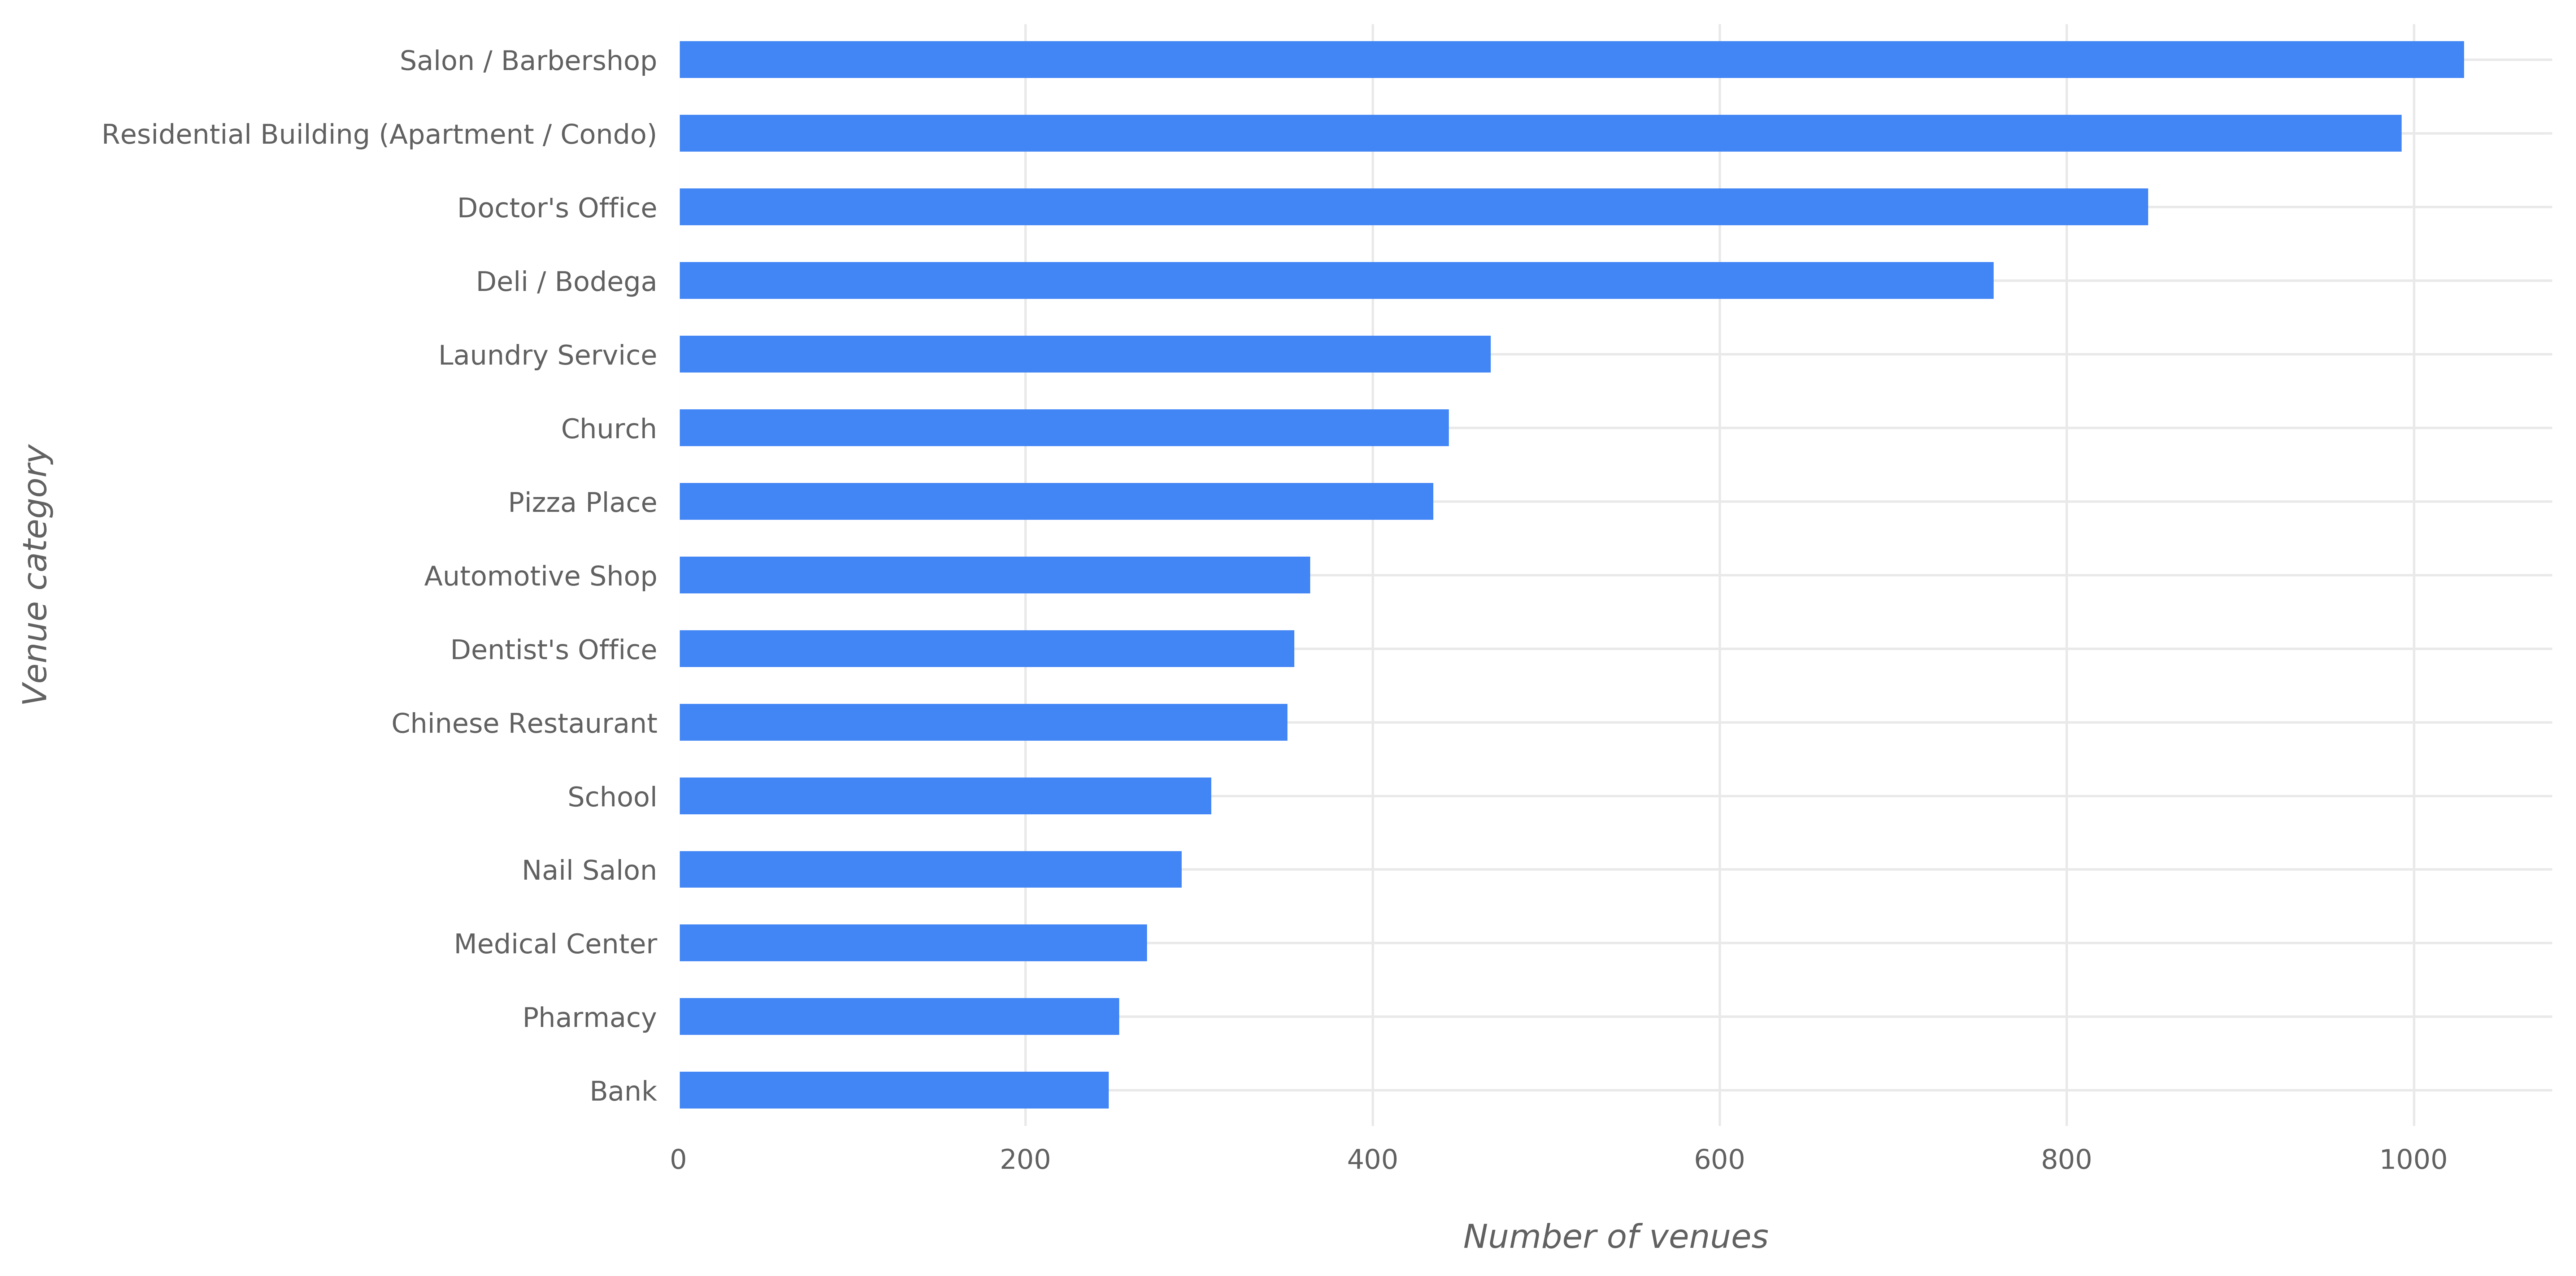

In [74]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

# Toronto Venues

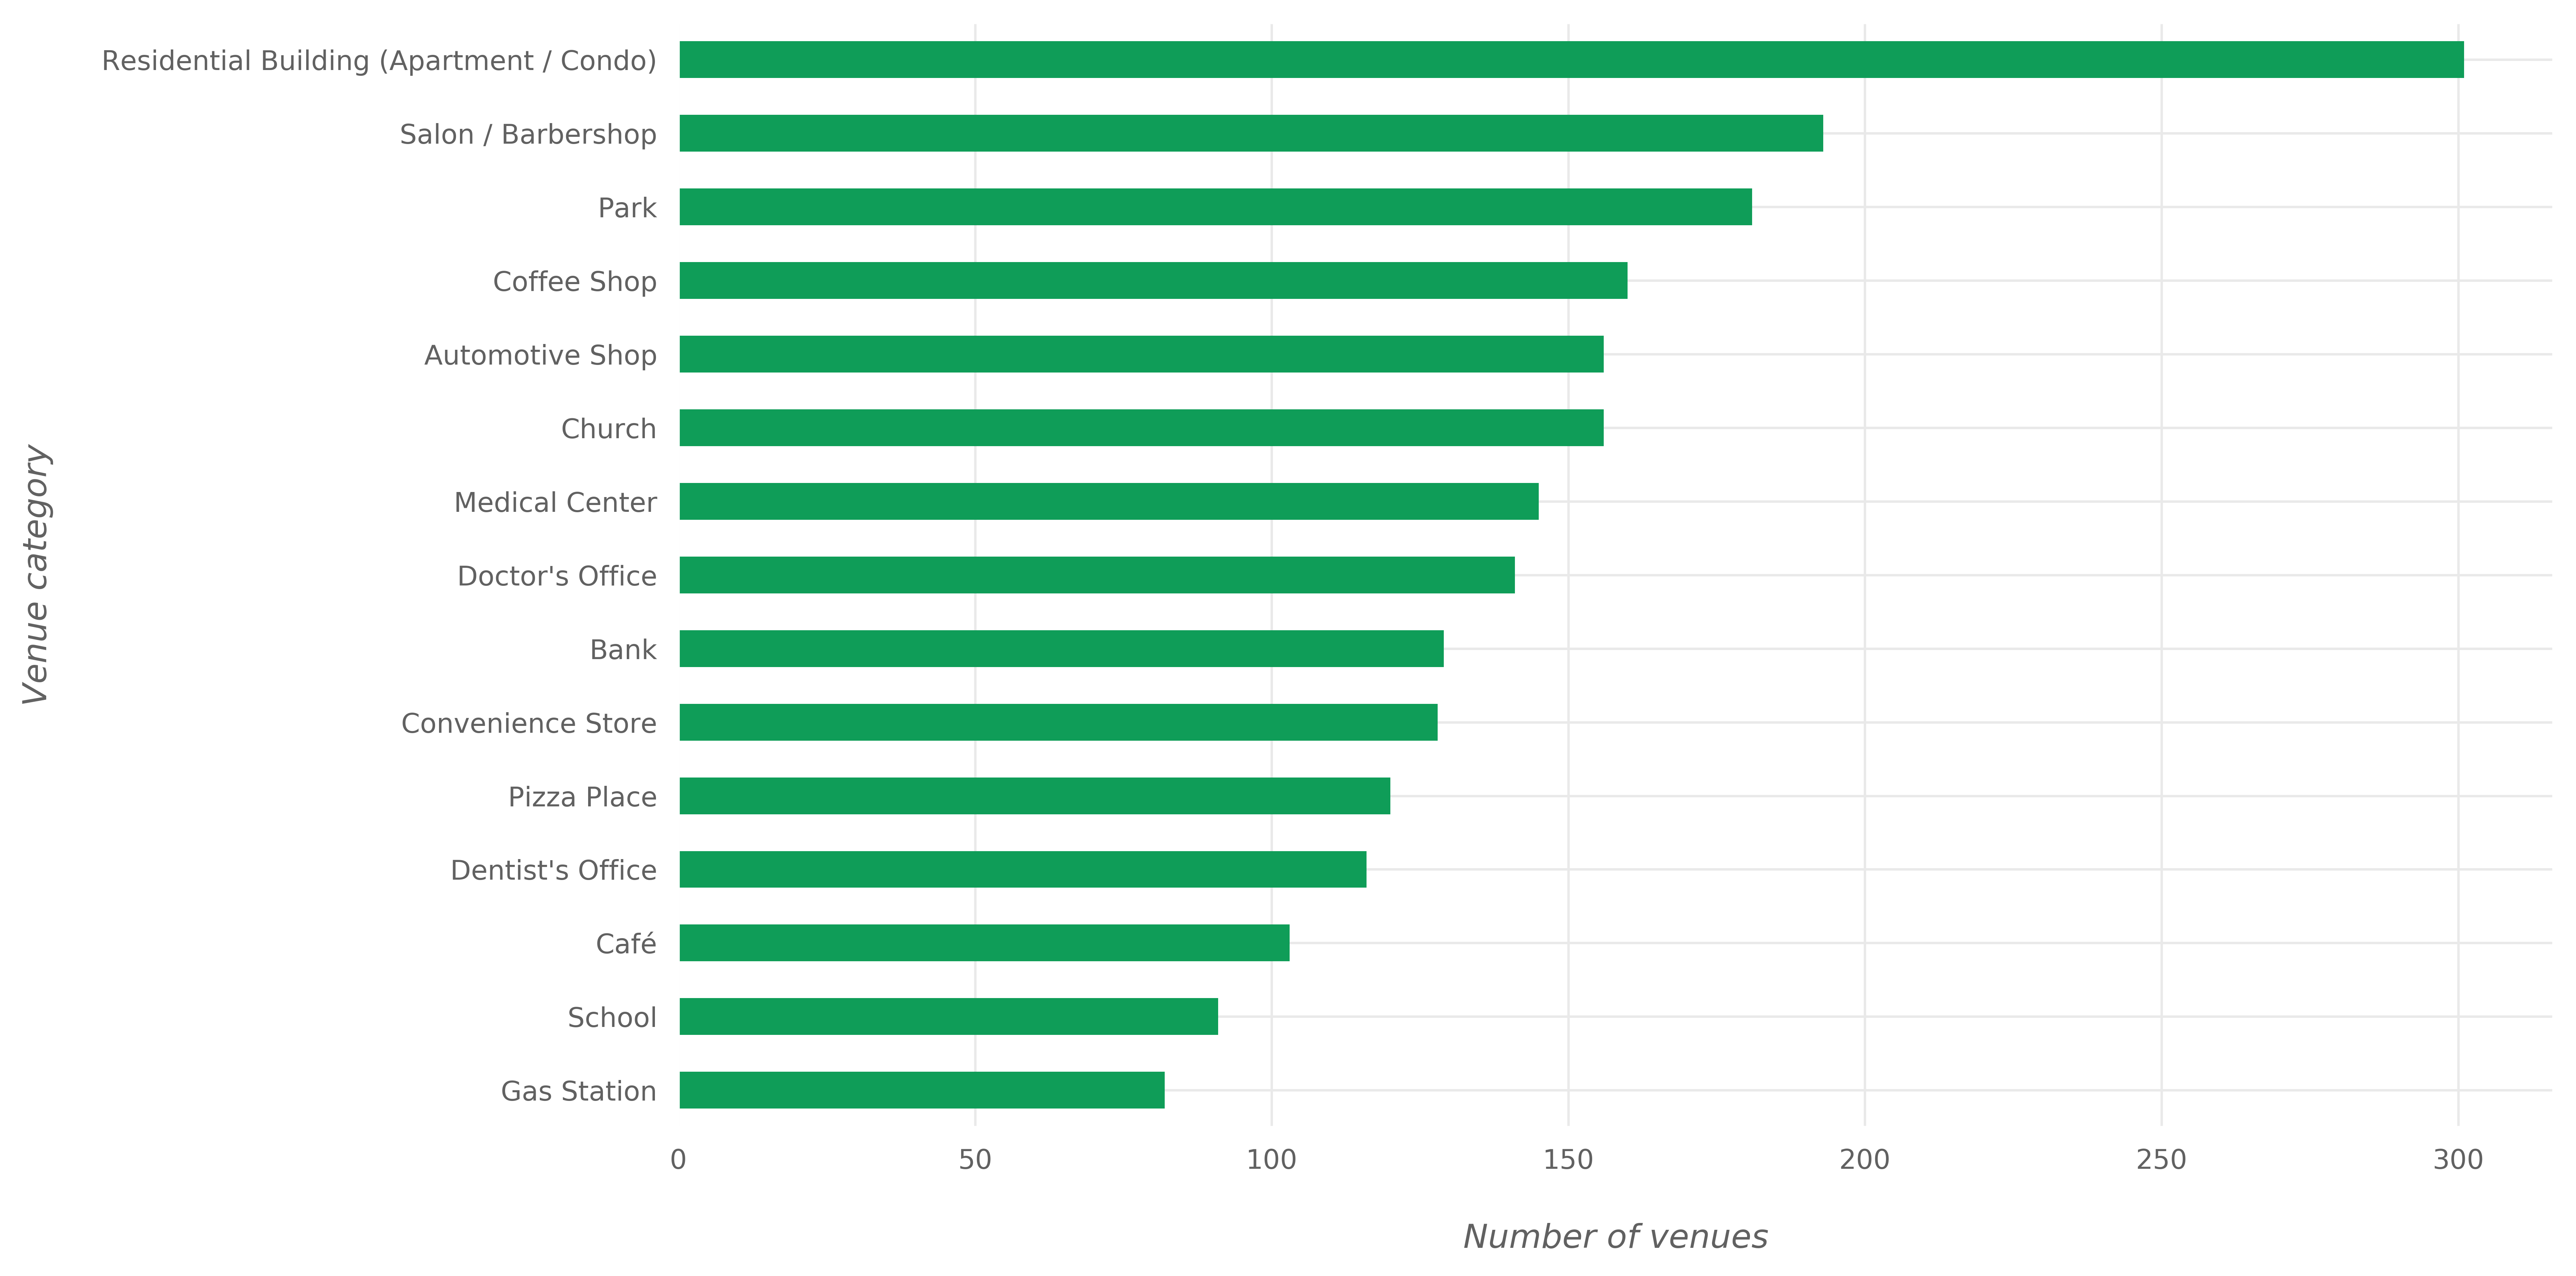

In [75]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

306 neighborhoods in NYC


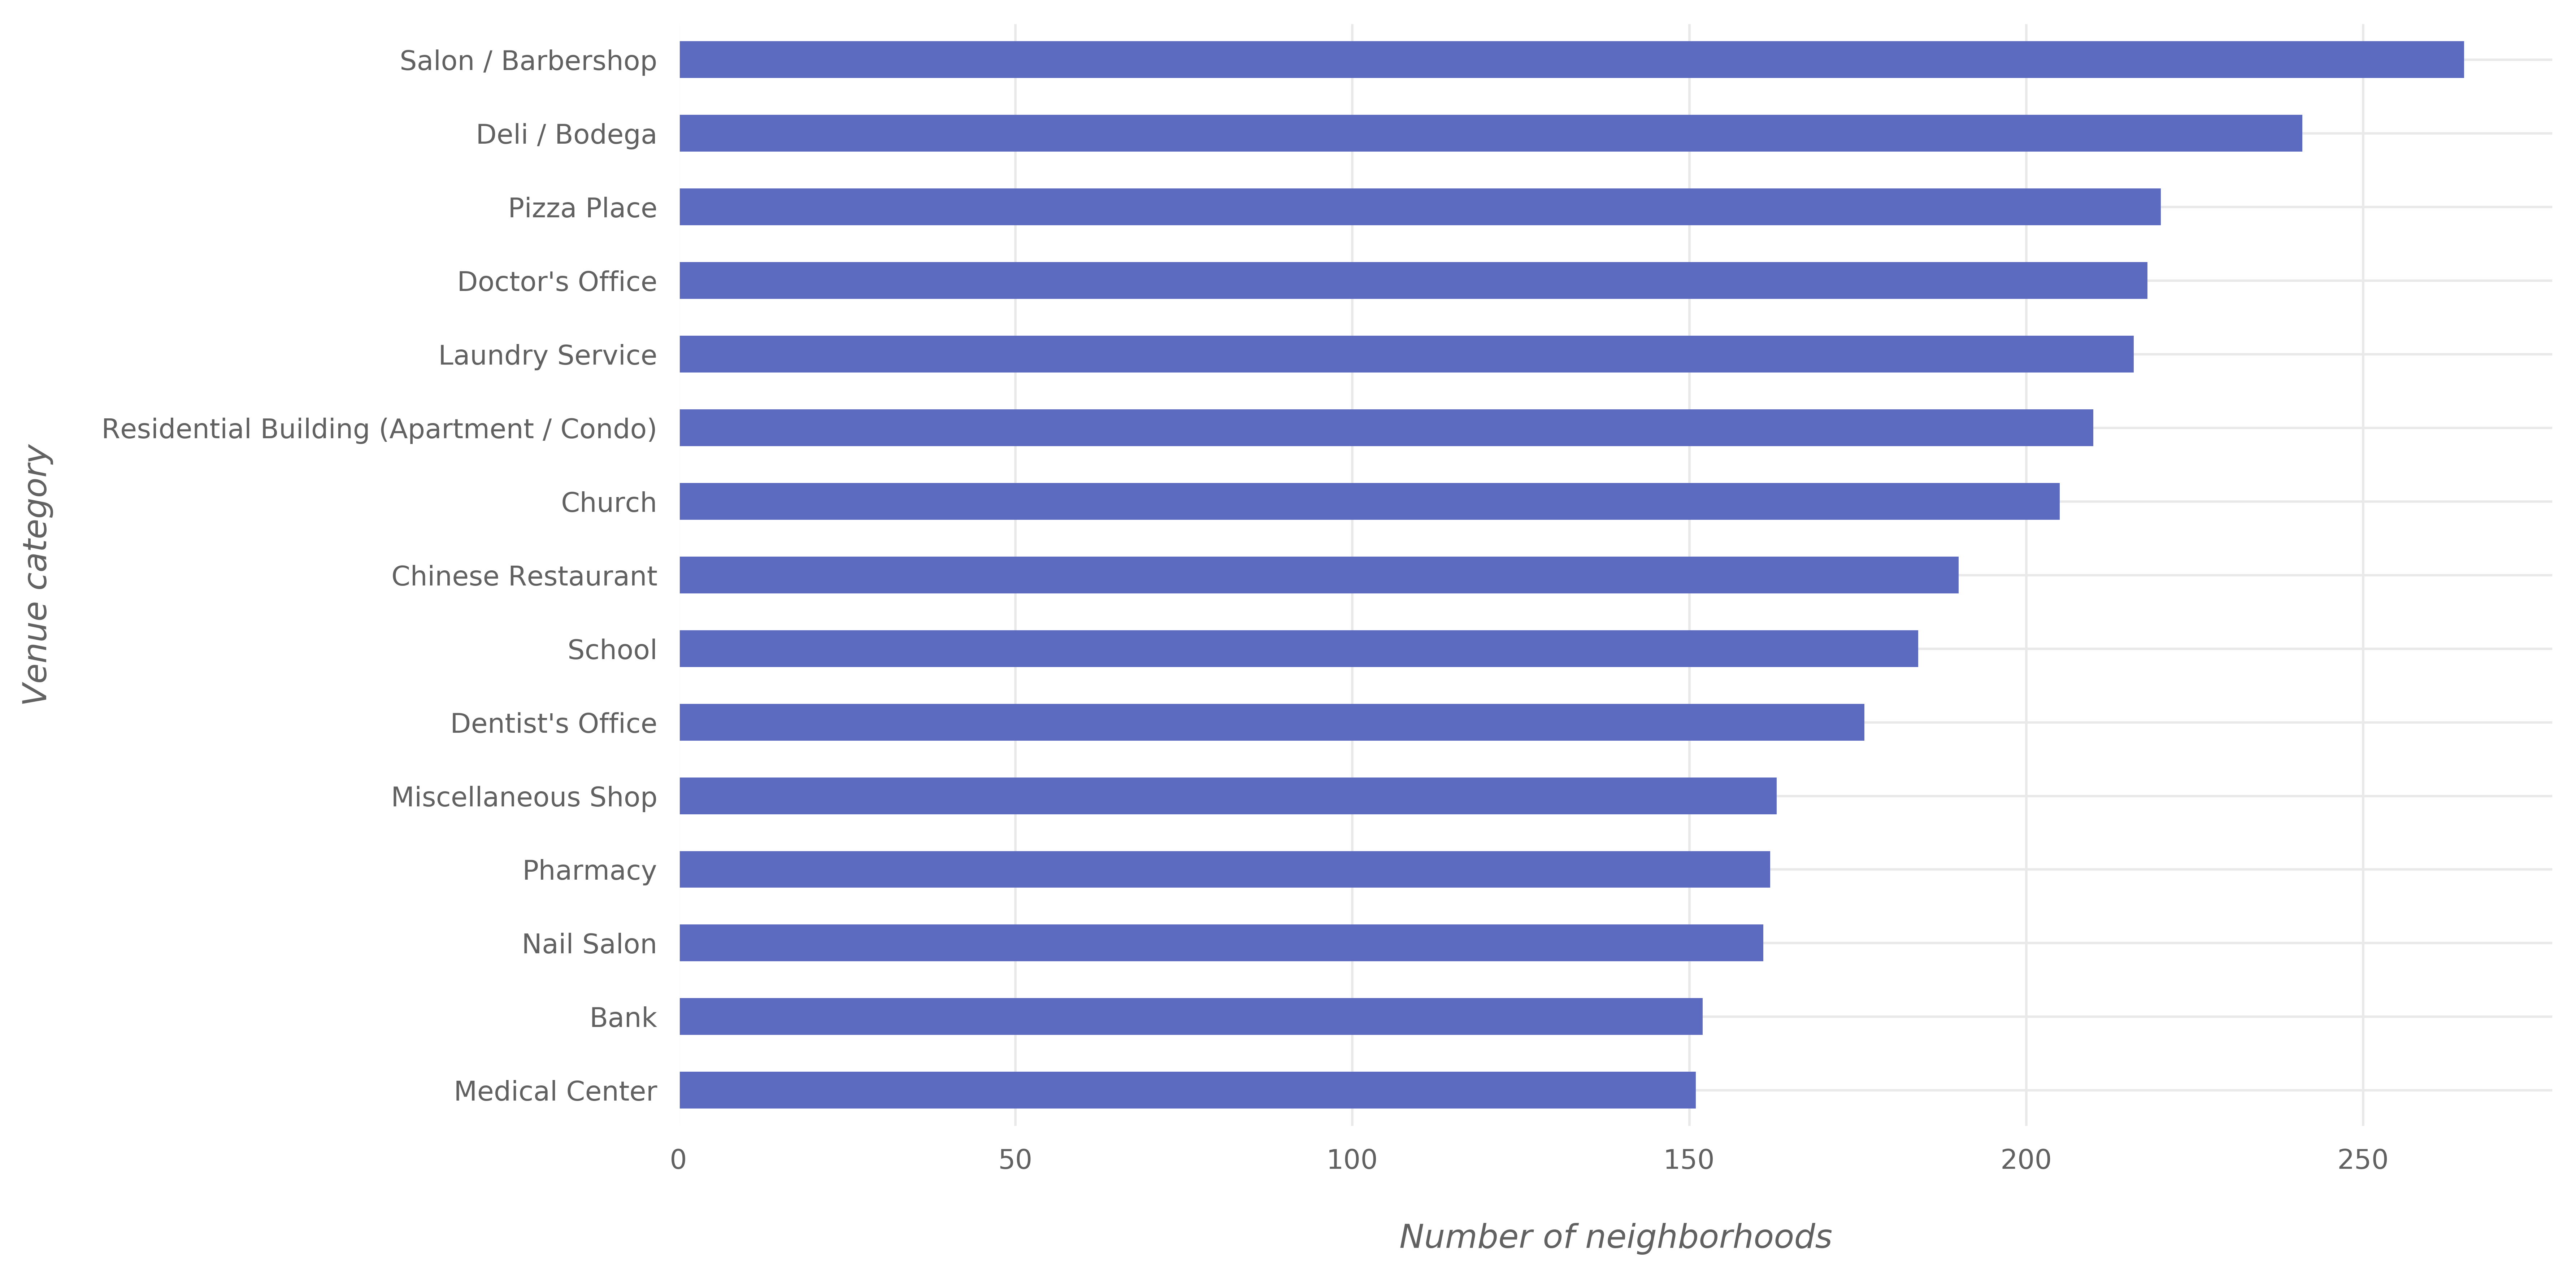

In [77]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = nyc_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

103 neighborhoods in Toronto


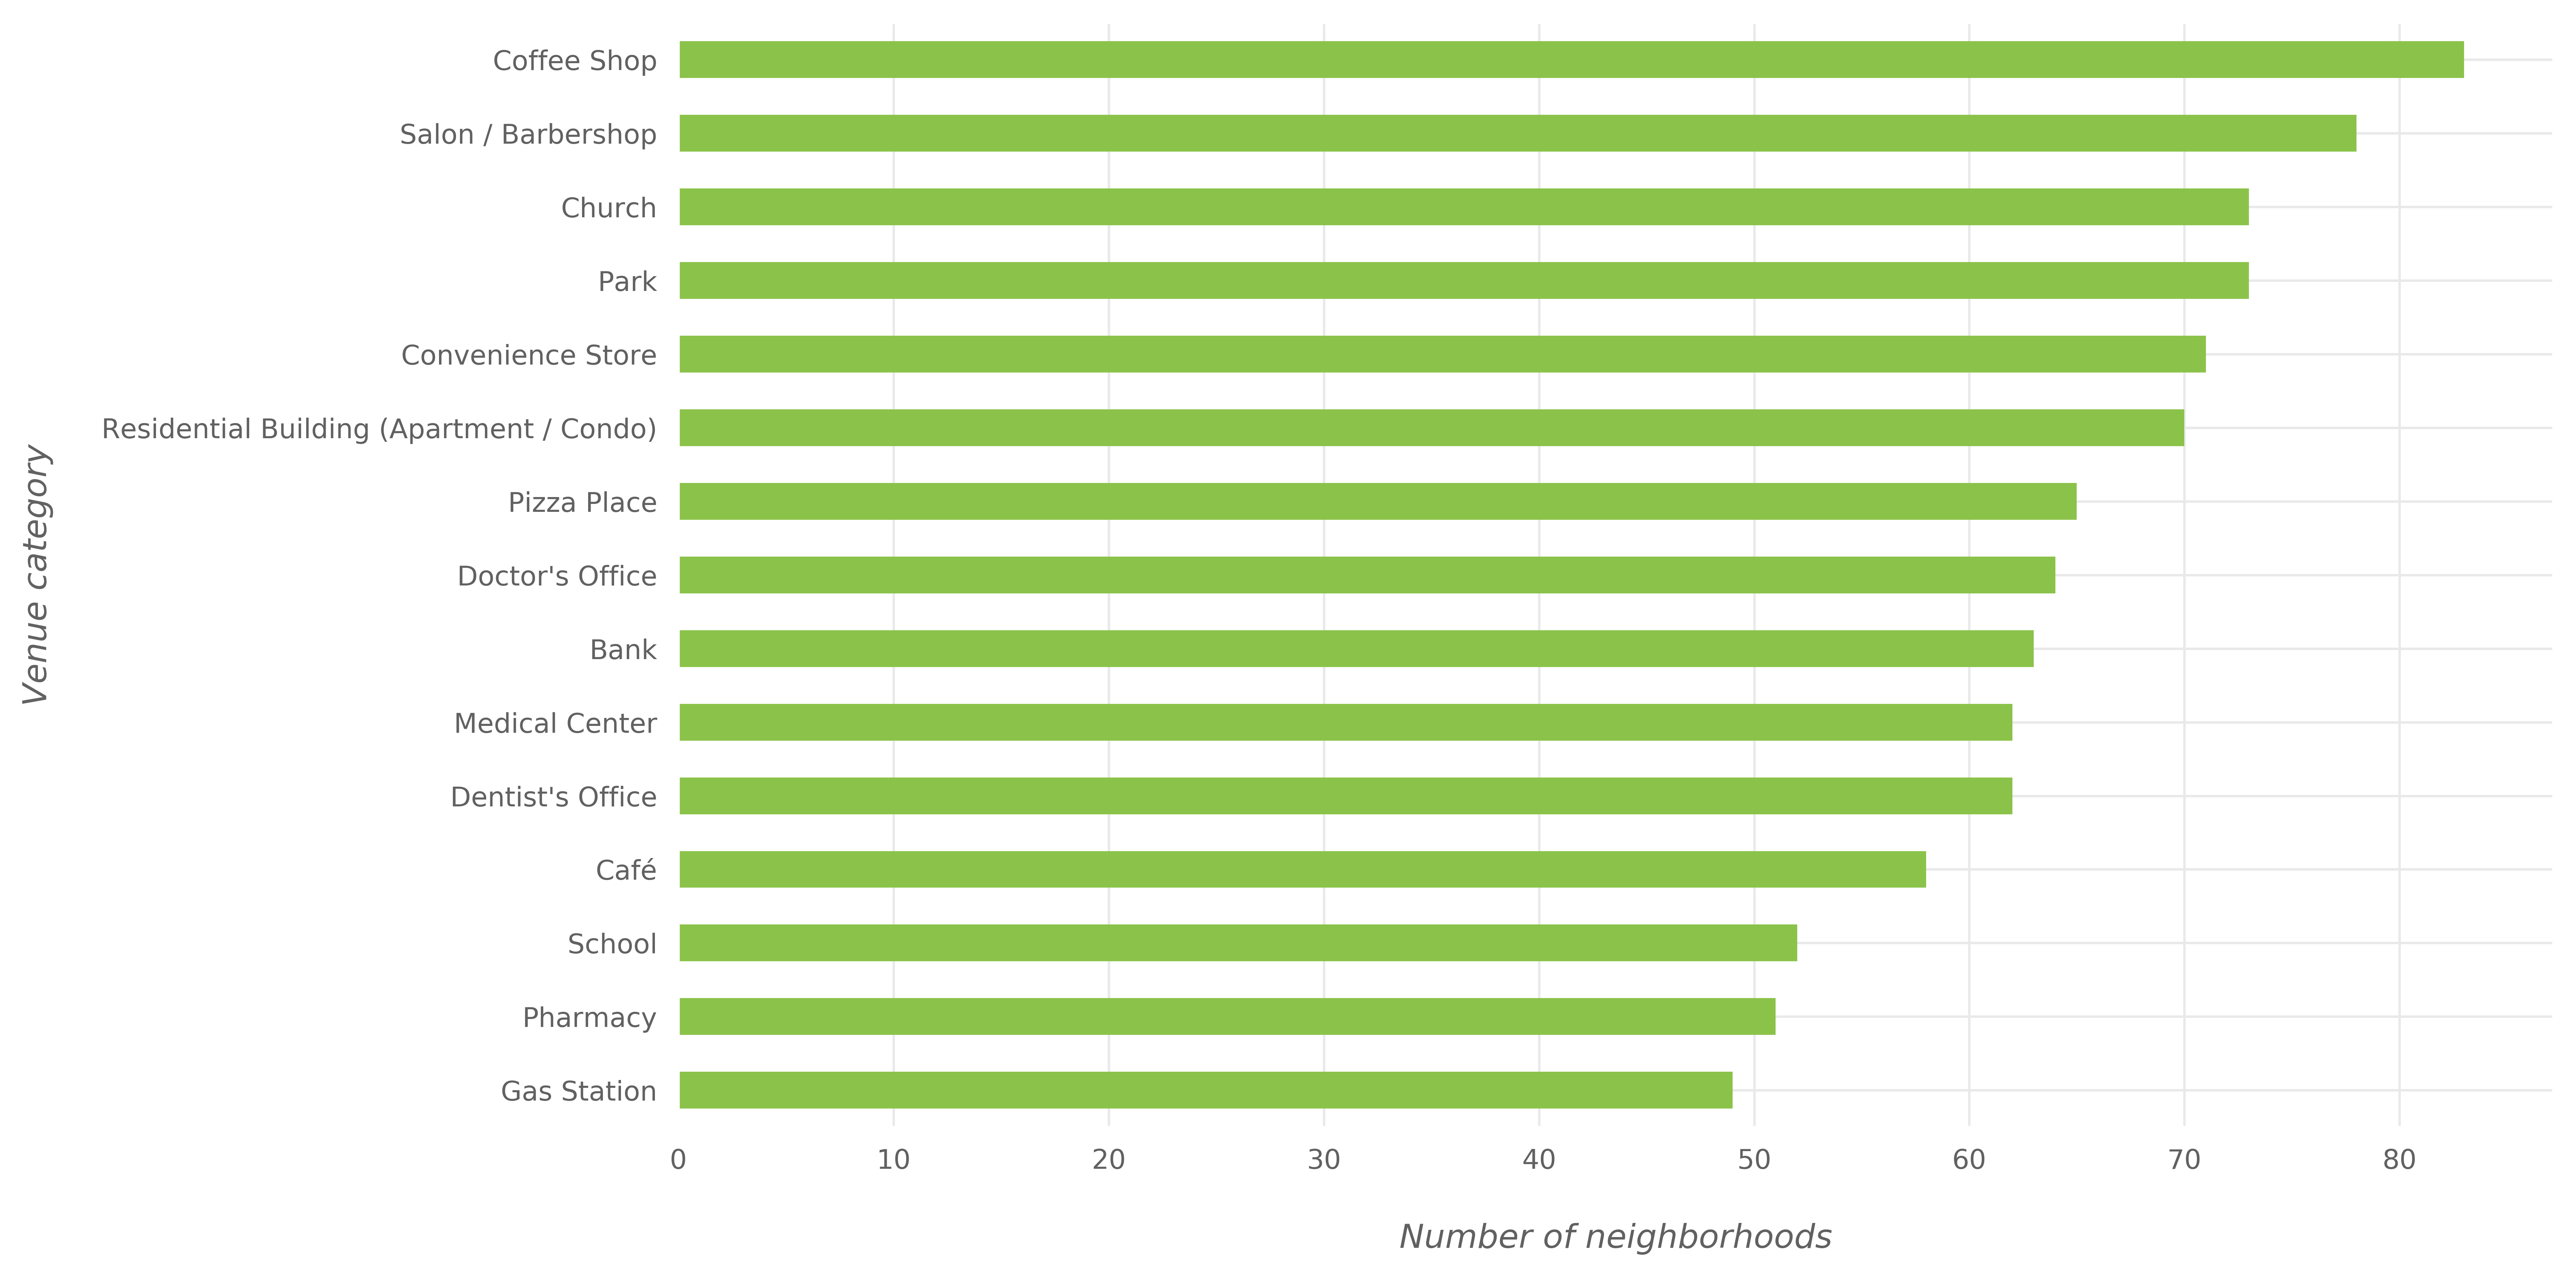

In [78]:

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

In [79]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category                  
Caucasian Restaurant           1
Tennis Stadium                 1
Public Bathroom                1
Theme Restaurant               1
Indian Sweet Shop              1
Australian Restaurant          1
Outlet Mall                    1
Ballroom                       1
Buffet                         1
Japanese Curry Restaurant      1
Brazilian Restaurant           1
Light Rail Station             1
Roller Rink                    1
Dosa Place                     1
Hawaiian Restaurant            1

In [80]:

tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category                 
Internet Cafe                 1
Swim School                   1
Marijuana Dispensary          1
Ethiopian Restaurant          1
College History Building      1
College Track                 1
Film Studio                   1
Baggage Claim                 1
Pop-Up Shop                   1
Ski Lodge                     1
EV Charging Station           1
College Hockey Rink           1
Zoo                           1
College Theater               1
Mountain                      1

In [81]:
clmns_nyc_only = set(nyc_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(nyc_grouped.columns))

In [82]:

nyc_grouped_ = nyc_grouped.copy()
nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [83]:
nyc_tor_grouped.loc[303:308,]

Neighborhood_  Accessories Store  \
303                                        Woodrow_NYC                0.0   
304                                       Woodside_NYC                0.0   
305                                      Yorkville_NYC                0.0   
306                   Adelaide, King, Richmond_Toronto                0.0   
307                                  Agincourt_Toronto                0.0   
308  Agincourt North, L'Amoreaux East, Milliken, St...                0.0   

     Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
303       0.000000             0.0                 0.0                0.0   
304       0.000000             0.0                 0.0                0.0   
305       0.011494             0.0                 0.0                0.0   
306       0.000000             0.0                 0.0                0.0   
307       0.000000             0.0                 0.0                0.0   
308       0.000000             0.0                 0.0                0.0   

     African Restaurant  Airport  Airport Food Court  Airport Gate  \
303                 0.0      0.0                 0.0           0.0   
304                 0.0      0.0                 0.0           0.0   
305                 0.0      0.0                 0.0           0.0   
306                 0.0      0.0                 0.0           0.0   
307                 0.0      0.0                 0.0           0.0   
308                 0.0      0.0                 0.0           0.0   

     Airport Lounge  Airport Service  Airport Terminal  Airport Tram  \
303             0.0              0.0               0.0           0.0   
304             0.0              0.0               0.0           0.0   
305             0.0              0.0               0.0           0.0   
306             0.0              0.0               0.0           0.0   
307             0.0              0.0               0.0           0.0   
308             0.0              0.0               0.0           0.0   

     Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
303                 0.0             0.012658             0.0           0.0   
304                 0.0             0.000000             0.0           0.0   
305                 0.0             0.000000             0.0           0.0   
306                 0.0             0.012346             0.0           0.0   
307                 0.0             0.000000             0.0           0.0   
308                 0.0             0.000000             0.0           0.0   

     Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
303     0.0               0.0                     0.0     0.025316   
304     0.0               0.0                     0.0     0.000000   
305     0.0               0.0                     0.0     0.011494   
306     0.0               0.0                     0.0     0.012346   
307     0.0               0.0                     0.0     0.000000   
308     0.0               0.0                     0.0     0.000000   

     Art Museum  Art Studio  Arts & Crafts Store  Arts & Entertainment  \
303         0.0         0.0             0.000000                   0.0   
304         0.0         0.0             0.000000                   0.0   
305         0.0         0.0             0.000000                   0.0   
306         0.0         0.0             0.000000                   0.0   
307         0.0         0.0             0.000000                   0.0   
308         0.0         0.0             0.017241                   0.0   

     Asian Restaurant  Assisted Living  Astrologer  Athletics & Sports  \
303          0.000000              0.0         0.0            0.012658   
304          0.000000              0.0         0.0            0.000000   
305          0.000000              0.0         0.0            0.000000   
306          0.012346              0.0         0.0            0.000000   
307          0.000000              0.0

In [84]:

nyc_tor_grouped.shape

(409, 621)

In [85]:
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood_'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood_     1st Most Common Category  \
0       Allerton_NYC           Salon / Barbershop   
1       Annadale_NYC           Salon / Barbershop   
2  Arden Heights_NYC  Professional & Other Places   
3      Arlington_NYC                       Church   
4       Arrochar_NYC                Deli / Bodega   

      2nd Most Common Category 3rd Most Common Category  \
0              Laundry Service                 Car Wash   
1                  Pizza Place            Tattoo Parlor   
2                         Pool            Moving Target   
3  Professional & Other Places       Salon / Barbershop   
4                   Food Truck          Doctor's Office   

  4th Most Common Category 5th Most Common Category  \
0               Non-Profit              Gas Station   
1      American Restaurant               Nail Salon   
2                   Church       Salon / Barbershop   
3           Hardware Store      Housing Development   
4              Pizza Place               Nail Salon   

                   6th Most Common Category 7th Most Common Category  
0                                  Pharmacy          Automotive Shop  
1                                Restaurant             Veterinarian  
2                           Doctor's Office         Dentist's Office  
3  Residential Building (Apartment / Condo)            Boat or Ferry  
4                               Event Space             Liquor Store

In [86]:

nyc_tor_bot_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category                  
Mobility Store                 1
Rugby Pitch                    1
Japanese Curry Restaurant      1
Pastry Shop                    1
College History Building       1
Roller Rink                    1
Rock Climbing Spot             1
Stoop Sale                     1
Street Fair                    1
Souvlaki Shop                  1
Paintball Field                1
Ethiopian Restaurant           1
Varenyky restaurant            1
Hungarian Restaurant           1
Hawaiian Restaurant            1

In [87]:
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 3, 1, 1, 2, 3, 0, 3], dtype=int32)

In [88]:
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

nyc_tor_merged.iloc[300:310]

Cluster Labels  \
Neighborhood_                                                        
Wingate_NYC                                                      3   
Woodhaven_NYC                                                    3   
Woodlawn_NYC                                                     3   
Woodrow_NYC                                                      1   
Woodside_NYC                                                     3   
Yorkville_NYC                                                    2   
Adelaide, King, Richmond_Toronto                                 1   
Agincourt_Toronto                                                0   
Agincourt North, L'Amoreaux East, Milliken, Ste...               1   
Albion Gardens, Beaumond Heights, Humbergate, J...               3   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Wingate_NYC                                                               Salon / Barbershop   
Woodhaven_NYC                                                             Salon / Barbershop   
Woodlawn_NYC                                                                             Bar   
Woodrow_NYC                                                                             Pool   
Woodside_NYC                                                              Salon / Barbershop   
Yorkville_NYC                                       Residential Building (Apartment / Condo)   
Adelaide, King, Richmond_Toronto                                                 Coffee Shop   
Agincourt_Toronto                                                            Automotive Shop   
Agincourt North, L'Amoreaux East, Milliken, Ste...                        Chinese Restaurant   
Albion Gardens, Beaumond Heights, Humbergate, J...                        Salon / Barbershop   

                                                   2nd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                          School   
Woodhaven_NYC                                                 Deli / Bodega   
Woodlawn_NYC                                             Salon / Barbershop   
Woodrow_NYC                                              Salon / Barbershop   
Woodside_NYC                                                            Bar   
Yorkville_NYC                                               Laundry Service   
Adelaide, King, Richmond_Toronto                                       Café   
Agincourt_Toronto                                                    Church   
Agincourt North, L'Amoreaux East, Milliken, Ste...                   School   
Albion Gardens, Beaumond Heights, Humbergate, J...            Movie Theater   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                   Deli / Bodega   
Woodhaven_NYC                                               Doctor's Office   
Woodlawn_NYC                                                  Deli / Bodega   
Woodrow_NYC                                                   Grocery Store   
Woodside_NYC                                                       Platform   
Yorkville_NYC                                                           Spa   
Adelaide, King, Richmond_Toronto                                 Food Court   
Agincourt_Toronto                                          Storage Facility   
Agincourt North, L'Amoreaux East, Milliken, Ste...          Doctor's Office   
Albion Gardens, Beaumond Heights, Humbergate, J...         Spiritual Center   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Wi

# Every Cluster

In [92]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.tail()

(27, 8)


Cluster Labels  \
Neighborhood_                                                        
Kingsway Park South West, Mimico NW, The Queens...               0   
Northwest_Toronto                                                0   
Rouge, Malvern_Toronto                                           0   
Scarborough Village_Toronto                                      0   
The Junction North, Runnymede_Toronto                            0   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Kingsway Park South West, Mimico NW, The Queens...                           Automotive Shop   
Northwest_Toronto                                                                    Factory   
Rouge, Malvern_Toronto                                                       Automotive Shop   
Scarborough Village_Toronto                         Residential Building (Apartment / Condo)   
The Junction North, Runnymede_Toronto                                        Automotive Shop   

                                                                    2nd Most Common Category  \
Neighborhood_                                                                                  
Kingsway Park South West, Mimico NW, The Queens...                           Coworking Space   
Northwest_Toronto                                                            Automotive Shop   
Rouge, Malvern_Toronto                                                               Factory   
Scarborough Village_Toronto                                                  Automotive Shop   
The Junction North, Runnymede_Toronto               Residential Building (Apartment / Condo)   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Kingsway Park South West, Mimico NW, The Queens...              Social Club   
Northwest_Toronto                                                     Hotel   
Rouge, Malvern_Toronto                                       Medical Center   
Scarborough Village_Toronto                                     Gas Station   
The Junction North, Runnymede_Toronto                 Vietnamese Restaurant   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Kingsway Park South West, Mimico NW, The Queens...       Miscellaneous Shop   
Northwest_Toronto                                           Auto Dealership   
Rouge, Malvern_Toronto                                      Doctor's Office   
Scarborough Village_Toronto                                     Pizza Place   
The Junction North, Runnymede_Toronto                        Breakfast Spot   

                                                   5th Most Common Category  \
Neighborhood_                                                                 
Kingsway Park South West, Mimico NW, The Queens...     Gym / Fitness Center   
Northwest_Toronto                                           Doctor's Office   
Rouge, Malvern_Toronto                                          Coffee Shop   
Scarborough Village_Toronto                                          Church   
The Junction North, Runnymede_Toronto                           Gas Station   

                                                       6th Most Common Category  \
Neighborhood_                                                                     
Kingsway Park South West, Mimico NW, The Queens...               Hardware Store   
Northwest_Toronto                                   Professional & Other Places   
Rouge, Malvern_Toronto                                       Salon / Barbershop   
Scarborough Village_Toronto                                Gym / Fitness Center   
The Junction North, Runnymede_Toronto                  

In [93]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2.tail()

(194, 8)


Cluster Labels  \
Neighborhood_                                             
Westmount_Toronto                                     1   
Willowdale South_Toronto                              1   
Woburn_Toronto                                        1   
Woodbine Gardens, Parkview Hill_Toronto               1   
Woodbine Heights_Toronto                              1   

                                                         1st Most Common Category  \
Neighborhood_                                                                       
Westmount_Toronto                                                            Park   
Willowdale South_Toronto                 Residential Building (Apartment / Condo)   
Woburn_Toronto                                                     Cosmetics Shop   
Woodbine Gardens, Parkview Hill_Toronto                         Convenience Store   
Woodbine Heights_Toronto                                                   Church   

                                        2nd Most Common Category  \
Neighborhood_                                                      
Westmount_Toronto                                Doctor's Office   
Willowdale South_Toronto                                    Bank   
Woburn_Toronto                                 Convenience Store   
Woodbine Gardens, Parkview Hill_Toronto                     Café   
Woodbine Heights_Toronto                                    Café   

                                        3rd Most Common Category  \
Neighborhood_                                                      
Westmount_Toronto                                    Pizza Place   
Willowdale South_Toronto                      Salon / Barbershop   
Woburn_Toronto                                          Pharmacy   
Woodbine Gardens, Parkview Hill_Toronto         Dentist's Office   
Woodbine Heights_Toronto                                    Park   

                                        4th Most Common Category  \
Neighborhood_                                                      
Westmount_Toronto                                           Bank   
Willowdale South_Toronto                                    Park   
Woburn_Toronto                                       Coffee Shop   
Woodbine Gardens, Parkview Hill_Toronto              Pizza Place   
Woodbine Heights_Toronto                      Salon / Barbershop   

                                                         5th Most Common Category  \
Neighborhood_                                                                       
Westmount_Toronto                                                     Gas Station   
Willowdale South_Toronto                                               Food Truck   
Woburn_Toronto                           Residential Building (Apartment / Condo)   
Woodbine Gardens, Parkview Hill_Toronto                                 Pet Store   
Woodbine Heights_Toronto                                             Skating Rink   

                                        6th Most Common Category  \
Neighborhood_                                                      
Westmount_Toronto                              Mobile Phone Shop   
Willowdale South_Toronto                         Bubble Tea Shop   
Woburn_Toronto                                       Pizza Place   
Woodbine Gardens, Parkview Hill_Toronto                     Bank   
Woodbine Heights_Toronto                            Fire Station   

                                                         7th Most Common Category  
Neighborhood_                                                                      
Westmount_Toronto                                                      Nail Salon  
Willowdale South_Toronto                                              Coffee Shop  
Woburn_Toronto                                                 Salon / Barbershop  
Woodbine Gardens, Parkview Hill_Toronto  Residential Building (Apartment / Condo)  
Woodbine Heights_Toront

In [91]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(54, 8)


Cluster Labels  \
Neighborhood_                                                 
Silver Hills, York Mills_Toronto                          2   
The Annex, North Midtown, Yorkville_Toronto               2   
Victoria Village_Toronto                                  2   
Willowdale West_Toronto                                   2   
York Mills West_Toronto                                   2   

                                                             1st Most Common Category  \
Neighborhood_                                                                           
Silver Hills, York Mills_Toronto             Residential Building (Apartment / Condo)   
The Annex, North Midtown, Yorkville_Toronto  Residential Building (Apartment / Condo)   
Victoria Village_Toronto                     Residential Building (Apartment / Condo)   
Willowdale West_Toronto                      Residential Building (Apartment / Condo)   
York Mills West_Toronto                      Residential Building (Apartment / Condo)   

                                            2nd Most Common Category  \
Neighborhood_                                                          
Silver Hills, York Mills_Toronto                                Park   
The Annex, North Midtown, Yorkville_Toronto          Bed & Breakfast   
Victoria Village_Toronto                             Automotive Shop   
Willowdale West_Toronto                                         Bank   
York Mills West_Toronto                                         Park   

                                            3rd Most Common Category  \
Neighborhood_                                                          
Silver Hills, York Mills_Toronto                              Church   
The Annex, North Midtown, Yorkville_Toronto                    Hotel   
Victoria Village_Toronto                                        Park   
Willowdale West_Toronto                               Medical Center   
York Mills West_Toronto                                          Gym   

                                            4th Most Common Category  \
Neighborhood_                                                          
Silver Hills, York Mills_Toronto                         High School   
The Annex, North Midtown, Yorkville_Toronto    General Entertainment   
Victoria Village_Toronto                                        Bank   
Willowdale West_Toronto                                         Park   
York Mills West_Toronto                               Medical Center   

                                            5th Most Common Category  \
Neighborhood_                                                          
Silver Hills, York Mills_Toronto                                Pool   
The Annex, North Midtown, Yorkville_Toronto                      Gym   
Victoria Village_Toronto                           Convenience Store   
Willowdale West_Toronto                                    Synagogue   
York Mills West_Toronto                              Laundry Service   

                                            6th Most Common Category  \
Neighborhood_                                                          
Silver Hills, York Mills_Toronto                              School   
The Annex, North Midtown, Yorkville_Toronto      Japanese Restaurant   
Victoria Village_Toronto                                        Food   
Willowdale West_Toronto                                     Cemetery   
York Mills West_Toronto                          Government Building   

                                            7th Most Common Category  
Neighborhood_                                                         
Silver Hills, York Mills_Toronto                           Synagogue  
The Annex, North Midtown, Yorkville_Toronto               Playground  
Victoria Village_Toronto                          Miscellaneous Shop  
Willowdale West_Toronto                                  Pizza Place  
York Mills West_Toronto     

In [94]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4.tail()

(93, 8)


Cluster Labels  \
Neighborhood_                                                        
Albion Gardens, Beaumond Heights, Humbergate, J...               3   
Bedford Park, Lawrence Manor East_Toronto                        3   
Caledonia-Fairbanks_Toronto                                      3   
Chinatown, Grange Park, Kensington Market_Toronto                3   
Weston_Toronto                                                   3   

                                                   1st Most Common Category  \
Neighborhood_                                                                 
Albion Gardens, Beaumond Heights, Humbergate, J...       Salon / Barbershop   
Bedford Park, Lawrence Manor East_Toronto                Salon / Barbershop   
Caledonia-Fairbanks_Toronto                              Salon / Barbershop   
Chinatown, Grange Park, Kensington Market_Toronto        Salon / Barbershop   
Weston_Toronto                                           Salon / Barbershop   

                                                                    2nd Most Common Category  \
Neighborhood_                                                                                  
Albion Gardens, Beaumond Heights, Humbergate, J...                             Movie Theater   
Bedford Park, Lawrence Manor East_Toronto                                                Spa   
Caledonia-Fairbanks_Toronto                                                           Bakery   
Chinatown, Grange Park, Kensington Market_Toronto                     Thrift / Vintage Store   
Weston_Toronto                                      Residential Building (Apartment / Condo)   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Albion Gardens, Beaumond Heights, Humbergate, J...         Spiritual Center   
Bedford Park, Lawrence Manor East_Toronto                Italian Restaurant   
Caledonia-Fairbanks_Toronto                                          Church   
Chinatown, Grange Park, Kensington Market_Toronto                  Boutique   
Weston_Toronto                                                  Pizza Place   

                                                                    4th Most Common Category  \
Neighborhood_                                                                                  
Albion Gardens, Beaumond Heights, Humbergate, J...                               Pizza Place   
Bedford Park, Lawrence Manor East_Toronto                                   Sushi Restaurant   
Caledonia-Fairbanks_Toronto                         Residential Building (Apartment / Condo)   
Chinatown, Grange Park, Kensington Market_Toronto                                        Bar   
Weston_Toronto                                                                          Park   

                                                   5th Most Common Category  \
Neighborhood_                                                                 
Albion Gardens, Beaumond Heights, Humbergate, J...                     Farm   
Bedford Park, Lawrence Manor East_Toronto                        Restaurant   
Caledonia-Fairbanks_Toronto                                            Park   
Chinatown, Grange Park, Kensington Market_Toronto     Vietnamese Restaurant   
Weston_Toronto                                              Doctor's Office   

                                                   6th Most Common Category  \
Neighborhood_                                                                 
Albion Gardens, Beaumond Heights, Humbergate, J...              Art Gallery   
Bedford Park, Lawrence Manor East_Toronto                 Convenience Store   
Caledonia-Fairbanks_Toronto                               Convenience Store   
Chinatown, Grange Park, Kensington Market_Toronto               Art Gallery   
Weston_Toronto                                                       Church   


In [95]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5.tail()

(41, 8)


Cluster Labels  \
Neighborhood_                                                        
Sunnyside, Staten Island_NYC                                     4   
Todt Hill_NYC                                                    4   
Tudor City_NYC                                                   4   
Upper East Side_NYC                                              4   
Bathurst Manor, Downsview North, Wilson Heights...               4   

                                                   1st Most Common Category  \
Neighborhood_                                                                 
Sunnyside, Staten Island_NYC                                Doctor's Office   
Todt Hill_NYC                                               Doctor's Office   
Tudor City_NYC                                              Doctor's Office   
Upper East Side_NYC                                         Doctor's Office   
Bathurst Manor, Downsview North, Wilson Heights...          Doctor's Office   

                                                                    2nd Most Common Category  \
Neighborhood_                                                                                  
Sunnyside, Staten Island_NYC                                                         Theater   
Todt Hill_NYC                                                             Salon / Barbershop   
Tudor City_NYC                                      Residential Building (Apartment / Condo)   
Upper East Side_NYC                                 Residential Building (Apartment / Condo)   
Bathurst Manor, Downsview North, Wilson Heights...  Residential Building (Apartment / Condo)   

                                                       3rd Most Common Category  \
Neighborhood_                                                                     
Sunnyside, Staten Island_NYC                                    College Library   
Todt Hill_NYC                                       Professional & Other Places   
Tudor City_NYC                                                   Medical Center   
Upper East Side_NYC                                                 Art Gallery   
Bathurst Manor, Downsview North, Wilson Heights...               Medical Center   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Sunnyside, Staten Island_NYC                         College Residence Hall   
Todt Hill_NYC                                                          Pool   
Tudor City_NYC                                         Gym / Fitness Center   
Upper East Side_NYC                                        Dentist's Office   
Bathurst Manor, Downsview North, Wilson Heights...                Synagogue   

                                                   5th Most Common Category  \
Neighborhood_                                                                 
Sunnyside, Staten Island_NYC                          College Arts Building   
Todt Hill_NYC                                                        School   
Tudor City_NYC                                                     Hospital   
Upper East Side_NYC                                          Medical Center   
Bathurst Manor, Downsview North, Wilson Heights...                     Bank   

                                                   6th Most Common Category  \
Neighborhood_                                                                 
Sunnyside, Staten Island_NYC                                   Dance Studio   
Todt Hill_NYC                                                      Pharmacy   
Tudor City_NYC                                                          Gym   
Upper East Side_NYC                                                 Library   
Bathurst Manor, Downsview North, Wilson Heights...       Salon / Barbershop   

                                                   7th Most Common Category  
Neighborhood

In [97]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [98]:

tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

# Acording to % Venues

In [99]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

In [100]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

# Toronto VS New York

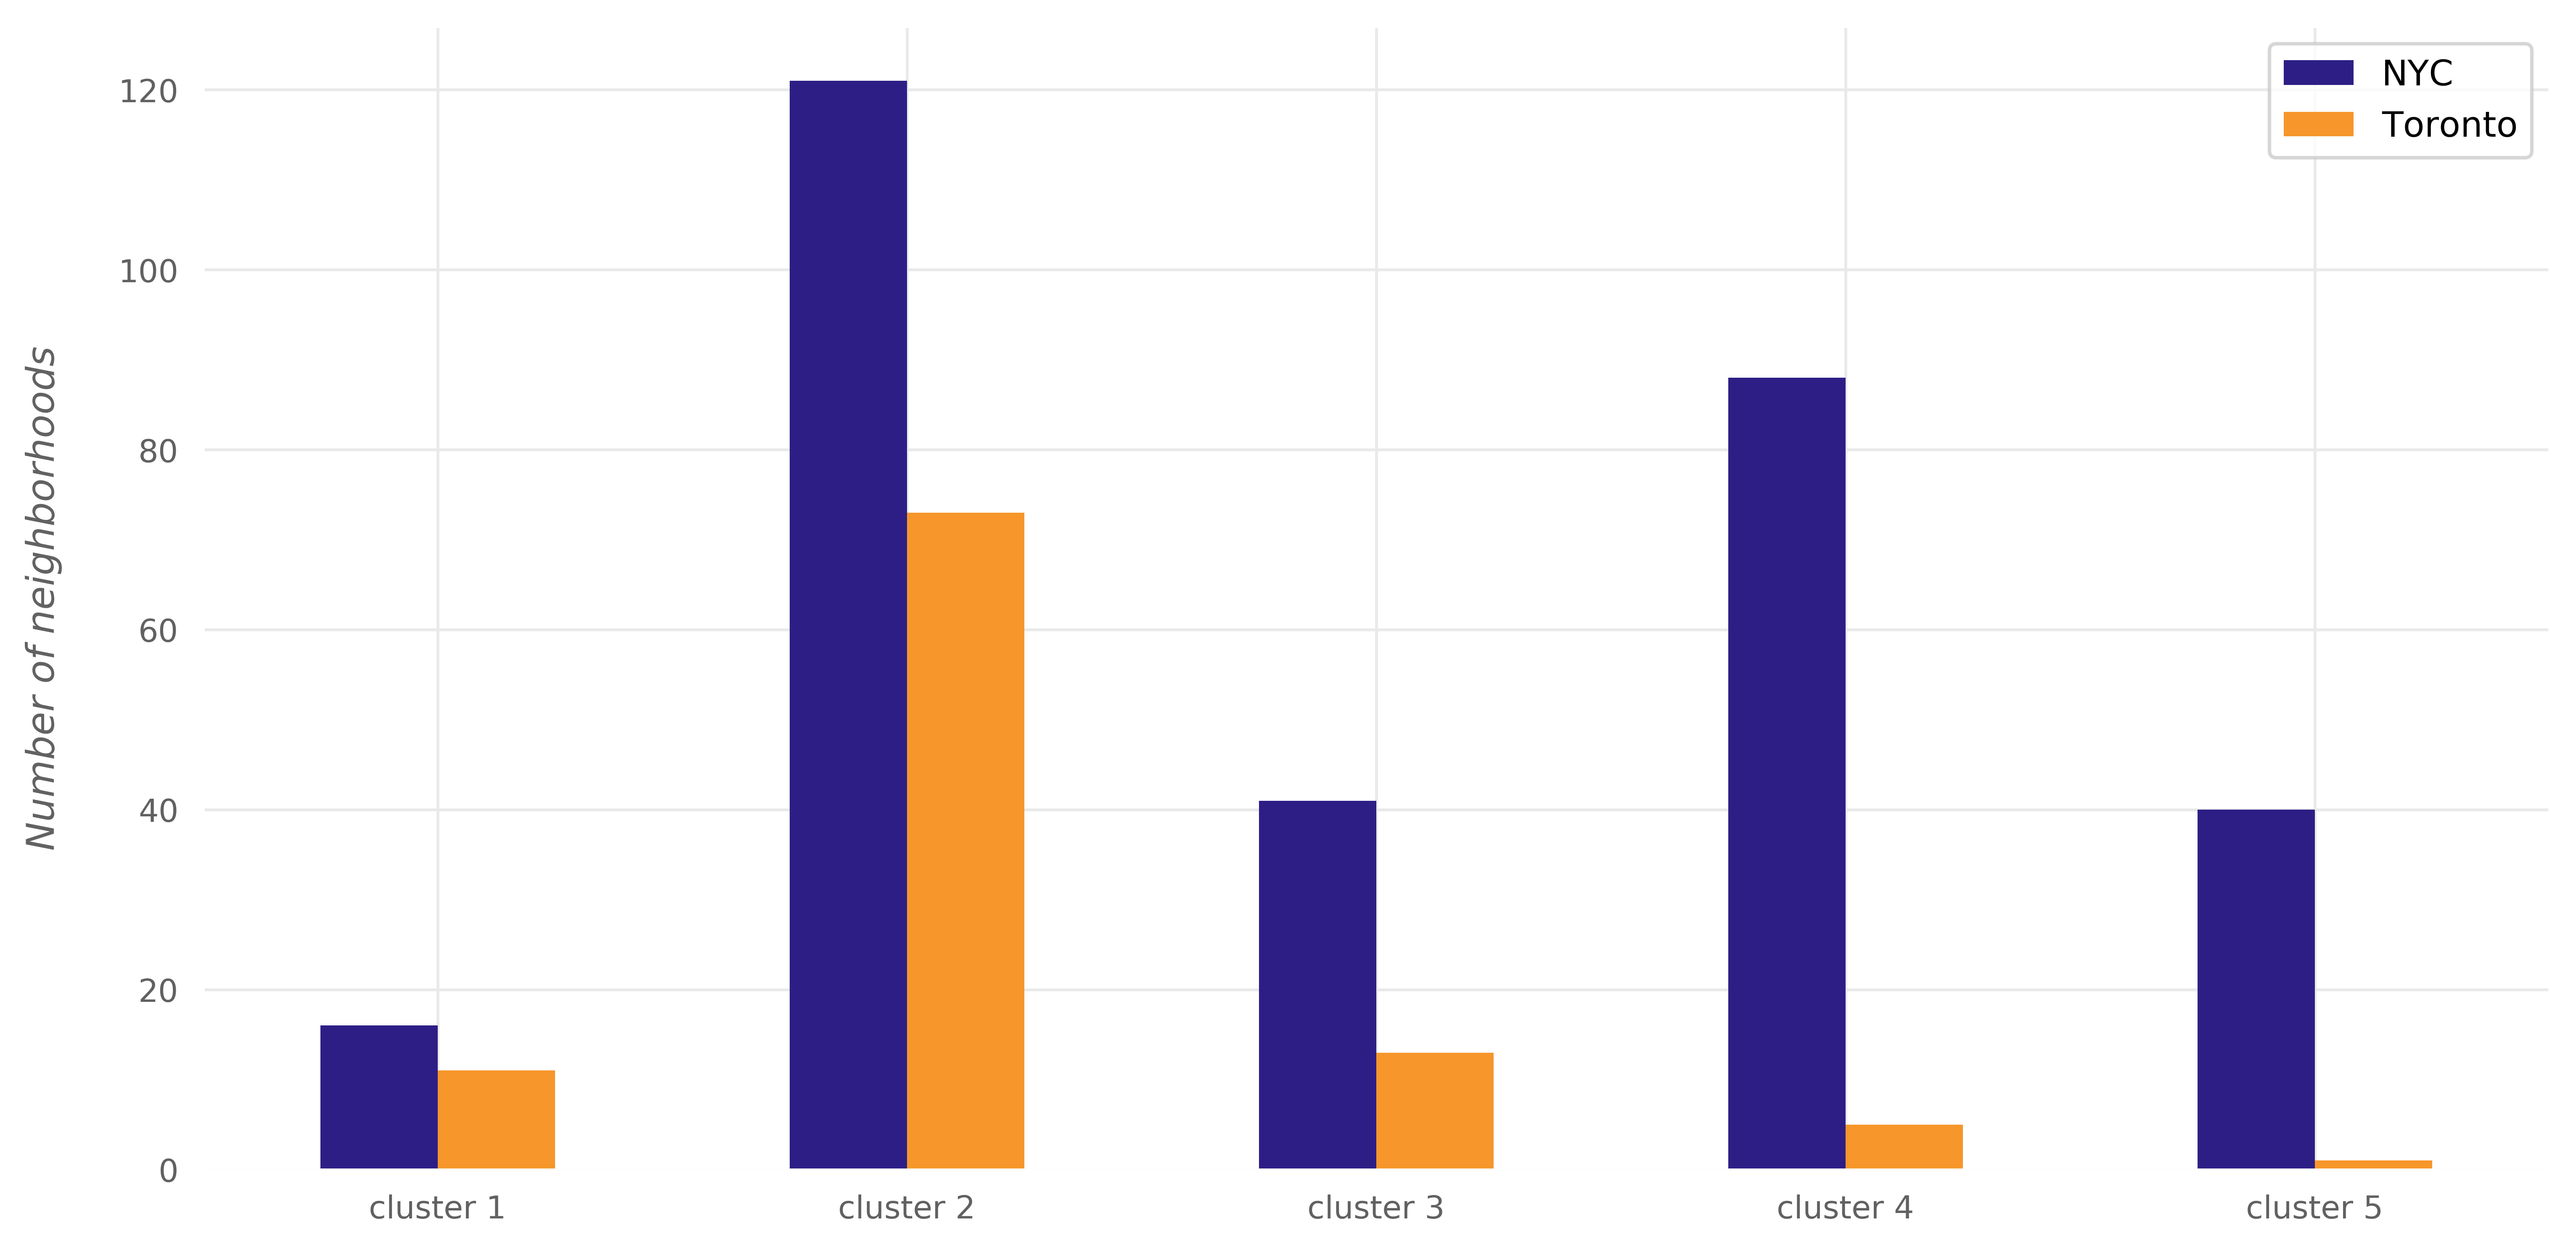

In [101]:

ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)